In [183]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

### Data exploration and extending the database

In [13]:
# load train data
labelled_data = pd.read_csv('MoodyLyricsPN.csv')

print('Data size:', labelled_data.shape, '\nData labels: ', list(labelled_data.columns.values))
print('Distribution of mood/sentiment in data set\n', labelled_data['mood'].value_counts())

Data size: (5000, 4) 
Data labels:  ['index', 'artist', 'title', 'mood']
Distribution of mood/sentiment in data set
 pos    2500
neg    2500
Name: mood, dtype: int64


The train data consists of the labels ['index', 'artist', 'title', 'mood'] and has 5000 elements with an even distribution in each of the classes positive and negative. To train a sentiment analysis model, the dataset is extended with the lyrics. This is done in the file ***getLyrics.py*** and saved to a separate csv-file and imported in the next cell. Something to take note of is that the lyrics to some songs could not be retrieved and therefore there is less data in the extended dataset. 

In [50]:
# import the extended dataset
extended_data = pd.read_csv('train-data_extended.csv')

print('Data size:', extended_data.shape, '\nData labels: ', list(extended_data.columns.values))
print('Distribution of mood/sentiment in data set\n', extended_data['mood'].value_counts())

print('\nRaw data')
print(extended_data['lyrics']) # there are many \n -- remove these
extended_data['lyrics'] = extended_data['lyrics'].str.replace('\n', ' ') 
print('\nProcessed data')
print(extended_data['lyrics'])

Data size: (4801, 5) 
Data labels:  ['index', 'artist', 'title', 'mood', 'lyrics']
Distribution of mood/sentiment in data set
 pos    2415
neg    2386
Name: mood, dtype: int64

Raw data
0       I know you'll tell me all\nNot to fall\nI lean...
1       I've been crying (Ooh, ooh)\n'Cause I'm lonely...
2       Goodbye cruel world\n\nOf this shape, a star o...
3       Warm and brown beneath the sun\nNever learned ...
4       Hurrying through the forks without regrets\nDi...
                              ...                        
4796    People tell us lies\nLies are all they know\nE...
4797    She's a very kinky girl\nThe kind you don't ta...
4798    And he won't fall into the sleep of the just\n...
4799    I've got a big, big, big heartbeat, yeah!\nI t...
4800    Quiet please, turn it off, shut it down\nSlow ...
Name: lyrics, Length: 4801, dtype: object

Processed data
0       I know you'll tell me all Not to fall I lean a...
1       I've been crying (Ooh, ooh) 'Cause I'm lonely ...
2 

In [51]:
# Split data into train and test set
from sklearn.model_selection import train_test_split

# split with 75-25 ratio into train and test set
train_data, test_data = train_test_split(extended_data, test_size=0.25, random_state=25)

print('Data size:', train_data.shape, '\nDistribution of mood/sentiment in data set\n', train_data['mood'].value_counts())
print('Data size:', test_data.shape, '\nDistribution of mood/sentiment in data set\n', test_data['mood'].value_counts())

x_train = train_data['lyrics'].astype('U').values
y_train = train_data['mood']

x_test = test_data['lyrics']
y_test = test_data['mood']

Data size: (3600, 5) 
Distribution of mood/sentiment in data set
 pos    1814
neg    1786
Name: mood, dtype: int64
Data size: (1201, 5) 
Distribution of mood/sentiment in data set
 pos    601
neg    600
Name: mood, dtype: int64


### Preprocessing and training model

In [53]:
# Preprocessing the lyrics using spacy
nlp = spacy.load('/usr/local/lib/python3.9/site-packages/en_core_web_lg/en_core_web_lg-3.4.1/') 

# remove stop words and punctations
def tokenize(text):
    text_tokens = nlp(text)
    res = [word.lemma_ for word in text_tokens if (not word.is_stop and not word.is_punct)]
    return res

In [207]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

vectorizer = CountVectorizer(tokenizer = tokenize)

Define pipelines to compare different classifiers in the binary classification problem 

In [208]:
# Naive-Bayes 
nb_pipe = Pipeline([('vectorizer', CountVectorizer(tokenizer = tokenize)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

nb_pipe.fit(x_train, y_train)
nb_pred = nb_pipe.predict(x_test)

print('Naive-Bayes classification report')
print(classification_report(y_test, nb_pred))


Naive-Bayes classification report
              precision    recall  f1-score   support

         neg       0.68      0.82      0.74       600
         pos       0.78      0.62      0.69       601

    accuracy                           0.72      1201
   macro avg       0.73      0.72      0.72      1201
weighted avg       0.73      0.72      0.72      1201



In [209]:
print('Training accuracy', nb_pipe.score(x_train, y_train))
print('Test accuracy', accuracy_score(y_test, nb_pred))

Training accuracy 0.8547222222222223
Test accuracy 0.7194004995836802


In [125]:
# Logistic regression
logreg_pipe = Pipeline([('vectorizer', vectorizer),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])
logreg_pipe.fit(x_train,y_train)
logreg_pred = logreg_pipe.predict(x_test)

print('Logistic regression classification report')
print(classification_report(y_test, logreg_pred))

Logistic regression classification report
              precision    recall  f1-score   support

         neg       0.74      0.72      0.73       600
         pos       0.73      0.75      0.74       601

    accuracy                           0.73      1201
   macro avg       0.73      0.73      0.73      1201
weighted avg       0.73      0.73      0.73      1201



In [122]:
# Support vector machine
svm_pipe = Pipeline([('vectorizer', vectorizer),
                ('tfidf', TfidfTransformer()),
                ('classifier', LinearSVC(loss='hinge'))])
svm_pipe.fit(x_train,y_train)
svm_pred = svm_pipe.predict(x_test)

print('Support vector machine classification report')
print(classification_report(y_test, svm_pred))

Support vector machine classification report
              precision    recall  f1-score   support

         neg       0.75      0.69      0.72       600
         pos       0.71      0.78      0.74       601

    accuracy                           0.73      1201
   macro avg       0.73      0.73      0.73      1201
weighted avg       0.73      0.73      0.73      1201



In [123]:
print('Logistic Regression')
print('Training accuracy', logreg_pipe.score(x_train, y_train))
print('Test accuracy', accuracy_score(y_test, logreg_pred))

print('SVM')
print('Training accuracy', svm_pipe.score(x_train, y_train))
print('Test accuracy', accuracy_score(y_test, svm_pred))

Logistic Regression
Training accuracy 0.8652777777777778
Test accuracy 0.7343880099916736
SVM
Training accuracy 0.8997222222222222
Test accuracy 0.7327227310574521


### Apply model to spotify dataset with valence value

In [10]:
spotify_data = pd.read_csv('labeled_lyrics_cleaned.csv')
print('Test data size:', spotify_data.shape, '\nTest data labels: ', list(spotify_data.columns.values))

Test data size: (158353, 5) 
Test data labels:  ['Unnamed: 0', 'artist', 'seq', 'song', 'label']


artist = artist name<br>
seq = song's lyrics<br>
song = song title<br>
label = Spotify valence feature attribute for this song

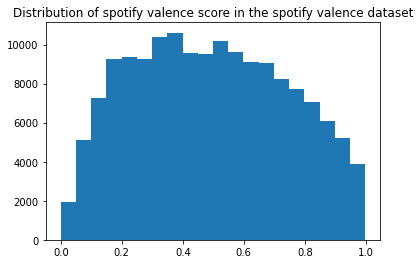

In [199]:
# Distribution of spotify valence value in the spotify dataset
# Spotify valence is "A measure from 0.0 to 1.0 describing the musical positiveness conveyed 
# by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), 
# while tracks with low valence sound more negative (e.g. sad, depressed, angry)." 
# (quoted from https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)

plt.hist(spotify_data['label'], bins=20)
plt.title('Distribution of spotify valence score in the spotify valence dataset')
plt.show()

# As seen in the histogram, the songs have valence values distributed across the [0, 1] interval 

In [212]:
print('Songs with valence < 0.5',spotify_data[spotify_data['label'] < 0.5 ]['label'].count())
print('Songs with valence >= 0.5',spotify_data[spotify_data['label'] >= 0.5 ]['label'].count())

Songs with valence < 0.5 82413
Songs with valence >= 0.5 75940


Logistic regression model and SVM model were close in the test accuracies, but the training accuracy and test accuracy of the logistic regression model were closer in score which indicates a less overfitted model compared to the SVM model. Therefore the logistic regression model is used in the rest of the codee. 

In [159]:
pred = logreg_pipe.predict(spotify_data['seq'])

pos    91185
neg    67168
Name: x, dtype: int64


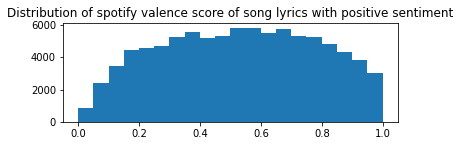

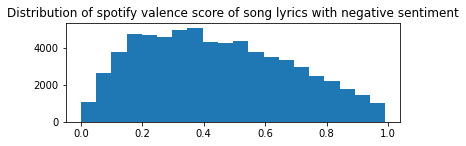

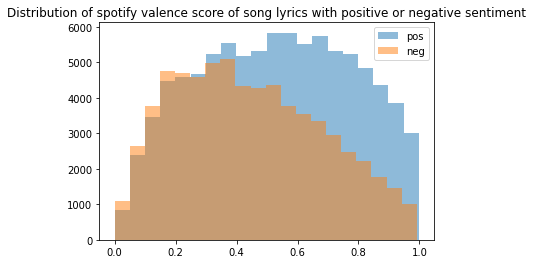

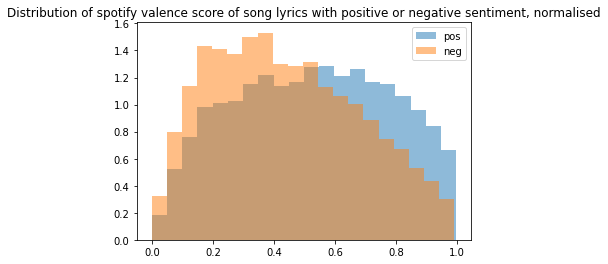

In [205]:
plot_data = pd.DataFrame({'x':pred, 'y':spotify_data['label']})
print(plot_data['x'].value_counts())
# separate plot_data into positive and negatives
pos_data, neg_data = plot_data[(mask:=plot_data['x'] == 'pos')], plot_data[~mask]

# plot pos and neg in separate histograms
plt.subplot(2, 1, 1)
plt.hist(pos_data['y'], bins=20)
plt.title('Distribution of spotify valence score of song lyrics with positive sentiment')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(neg_data['y'], bins=20)
plt.title('Distribution of spotify valence score of song lyrics with negative sentiment')
plt.show()

# plot pos and neg in same histogram
plt.hist(pos_data['y'], bins=20, alpha=0.5, label='pos')
plt.hist(neg_data['y'], bins=20, alpha=0.5, label='neg')
plt.legend()
plt.title('Distribution of spotify valence score of song lyrics with positive or negative sentiment')
plt.show()

# plot pos and neg in normalised histogram
plt.hist(pos_data['y'], bins=20, alpha=0.5, label='pos', density=True)
plt.hist(neg_data['y'], bins=20, alpha=0.5, label='neg', density=True)
plt.legend()
plt.title('Distribution of spotify valence score of song lyrics with positive or negative sentiment, normalised')
plt.show()

